# M-layer experiments
This notebook trains M-layers on the problems discussed in "Intelligent Matrix Exponentiation".

In [2]:
GLOBAL_SEED = 42
import numpy as np
np.random.seed(GLOBAL_SEED)
import itertools
import functools
import operator
import matplotlib.pyplot as plt
from matplotlib import pylab
import torch
from m_layer import MLayer
DEVICE = 'cpu'
from utils import NpDataset
from torch.utils.data import DataLoader
from ignite.engine import Engine
from ignite.metrics import Accuracy, Loss, Average
from ignite.engine import Events
from IPython.display import clear_output

### Creation of spiral task

In [3]:
from models import SpiralDNN, SpiralMLayer

SPIRAL_DIM_REP = 10
SPIRAL_DIM_MATRIX = 10
SPIRAL_LAYER_SIZE = 20
SPIRAL_BATCH_SIZE = 16
L2_REG=1e-4
SEED = 42


def spiral_generate(n_points, noise=0.5, extra_rotation=False):
    rng = np.random.RandomState(SEED)
    if not extra_rotation:
        n = np.sqrt(0.001 + (.25)*rng.rand(n_points, 1)) * 6 * (2 * np.pi)
    else:
        n = np.sqrt((7.0/36)*rng.rand(n_points, 1)+.25) * 6 * (2 * np.pi)
    x = 0.5 * (np.sin(n) * n + (2 * rng.rand(n_points, 1) - 1) * noise)
    y = 0.5 * (np.cos(n) * n + (2 * rng.rand(n_points, 1) - 1) * noise)
    return (np.vstack((np.hstack((x, y)), np.hstack((-x, -y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))


def spiral_run(model_type, expm):
  if model_type == 'dnn':
      model = SpiralDNN(SPIRAL_LAYER_SIZE, device=DEVICE)
  elif model_type == 'm_layer':
      model = SpiralMLayer(SPIRAL_DIM_REP, SPIRAL_DIM_MATRIX, expm, device=DEVICE, l2_reg=L2_REG)
  
  x_train, y_train = spiral_generate(1000)
  train_dl = DataLoader(
      NpDataset((x_train, y_train)), 
      batch_size=SPIRAL_BATCH_SIZE, shuffle=True, drop_last=True)
  x_test, y_test = spiral_generate(333, extra_rotation=True)
  test_dl = DataLoader(
      NpDataset((x_test, y_test)), 
      shuffle=False, drop_last=False)

  optimizer = torch.optim.RMSprop(model.parameters(), lr=SPIRAL_LR)

  test_accuracy = []
  train_loss = []
  test_loss = []
  train_accuracy = []
  expm_time = []
  expm_calls = []

  def update_model(engine, batch):
      inp, targ = batch
      inp = inp.float().to(DEVICE)
      targ = targ.to(DEVICE)
      optimizer.zero_grad()
      loss, pred = model.loss(inp, targ)
      loss.backward()
      optimizer.step()
      return loss.item()
  
  def eval_model(engine, batch):
      with torch.no_grad():
          inp, targ = batch
          inp = inp.float().to(DEVICE)
          targ = targ.to(DEVICE)
          loss, pred = model.loss(inp, targ)
          return loss.item(), pred.cpu(), targ.cpu()

  trainer = Engine(update_model)
  evaluator = Engine(eval_model)
  
  Accuracy(lambda output: (torch.round(output[1]), output[2])).attach(evaluator, 'accuracy')
  Average(lambda output: output[0]).attach(evaluator, 'loss')
  if model_type == 'm_layer':
    @trainer.on(Events.EPOCH_STARTED)
    def reset_time(trainer):
        expm.reset()

    @trainer.on(Events.EPOCH_COMPLETED)
    def update_time(trainer):
        time, calls = expm.release()
        expm_time.append(time)
        expm_calls.append(calls)
        expm.reset()

  @trainer.on(Events.EPOCH_COMPLETED(every=10))
  def log_validation_results(trainer):
      evaluator.run(test_dl)
      metrics = evaluator.state.metrics
      test_accuracy.append(metrics['accuracy'])
      test_loss.append(metrics['loss'])
      evaluator.run(train_dl)
      metrics = evaluator.state.metrics
      train_accuracy.append(metrics['accuracy'])
      train_loss.append(metrics['loss'])
      # if trainer.state.epoch % 10 == 0:
      clear_output(wait=True)
      _, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))
      ax[0, 0].plot(test_accuracy)
      ax[0, 0].set_title('Test accuracy')
      ax[0, 1].plot(test_loss)
      ax[0, 1].set_title('Test loss')
      ax[1, 0].plot(train_accuracy)
      ax[1, 0].set_title('Train accuracy')
      ax[1, 1].plot(train_loss)
      ax[1, 1].set_title('Train loss')
      plt.tight_layout()
      plt.show()
  
  trainer.run(train_dl, SPIRAL_EPOCHS)

  fig = pylab.figure(figsize=(8,8), dpi=77)
  delta = 0.5 ** 3
  xs = np.arange(-14, 14.01, delta)
  ys = np.arange(-14, 14.01, delta)
  num_samples = len(xs)
  a = []
  for x in xs:
    for y in ys:
      a.append([x, y])
  with torch.no_grad():
    res = model(torch.tensor(np.array(a)).float().to(DEVICE))
    if isinstance(res, tuple):
      res = res[0]
    t_nn_gen = torch.round(res.cpu()).numpy()
  axes = fig.gca()
  XX, YY = np.meshgrid(xs, ys)
  axes.contourf(XX, YY, np.arcsinh(t_nn_gen.reshape(XX.shape)),
             levels=[0.0, 0.5, 1.0],
             colors=[(0.41, 0.67, 0.81, 0.2), (0.89, 0.51, 0.41, 0.2)])
  axes.contour(XX, YY, np.arcsinh(t_nn_gen.reshape(XX.shape)),
             levels=[0.5])
  axes.set_aspect(1)
  axes.grid()
  axes.plot(x_train[y_train==0, 1], x_train[y_train==0, 0], '.', ms = 2,
            label='Class 1')
  axes.plot(x_train[y_train==1, 1], x_train[y_train==1, 0], '.', ms = 2,
            label='Class 2')
  plt.plot(x_test[y_test==1, 1], x_test[y_test==1, 0], '.', ms = 6,
            label='Class 2')
  plt.plot(x_test[y_test==0, 1], x_test[y_test==0, 0], '.', ms = 6,
            label='Class 1')
  return model, fig, train_accuracy, test_accuracy, expm_time, expm_calls

### Matrix exponential comparison
Here we solve spiral task for different matrix exponential methods

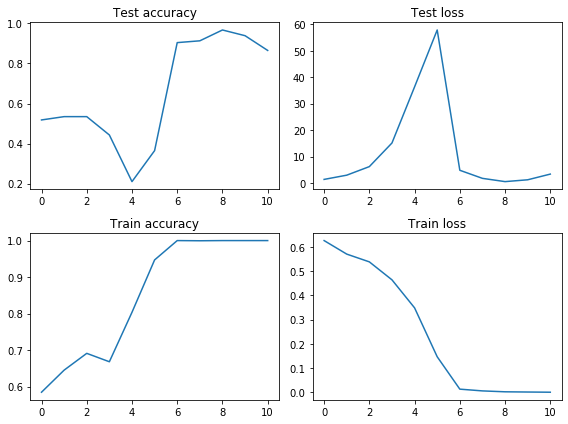

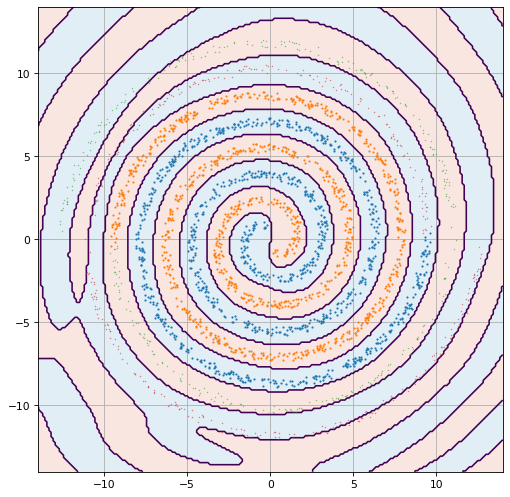

In [3]:
SPIRAL_LR = 0.001
SPIRAL_EPOCHS = 110
from matrix_exponentials import SecondGreatLimitExpm
res = spiral_run('m_layer', SecondGreatLimitExpm(6))

In [7]:
expm_time, expm_calls = res[-2], res[-1]
print('ms per expm call', np.sum(expm_time)/np.sum(expm_calls)*1000)
print('expm calls per epoch', np.mean(expm_calls))

ms per expm call 0.6556522681450753
expm calls per epoch 125.0


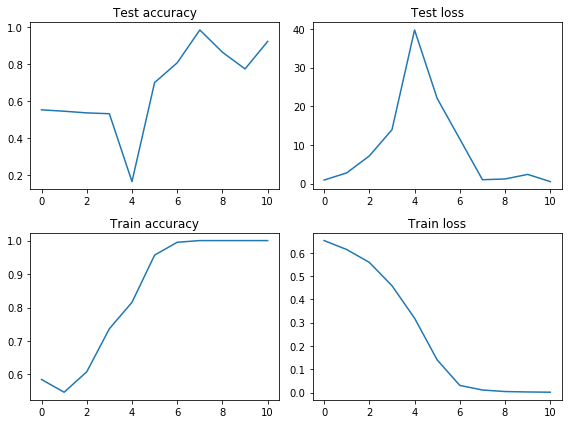

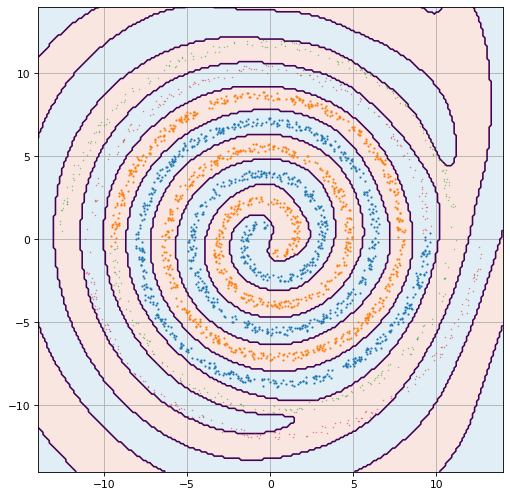

In [8]:
SPIRAL_LR = 0.001
SPIRAL_EPOCHS = 110
from matrix_exponentials import PadeExpm
res = spiral_run('m_layer', PadeExpm(6))

In [9]:
expm_time, expm_calls = res[-2], res[-1]
print('ms per expm call', np.sum(expm_time)/np.sum(expm_calls)*1000)
print('expm calls per epoch', np.mean(expm_calls))

ms per expm call 1.4088238861087037
expm calls per epoch 125.0


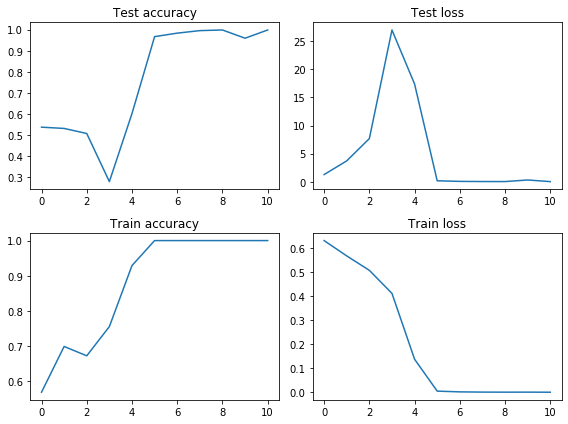

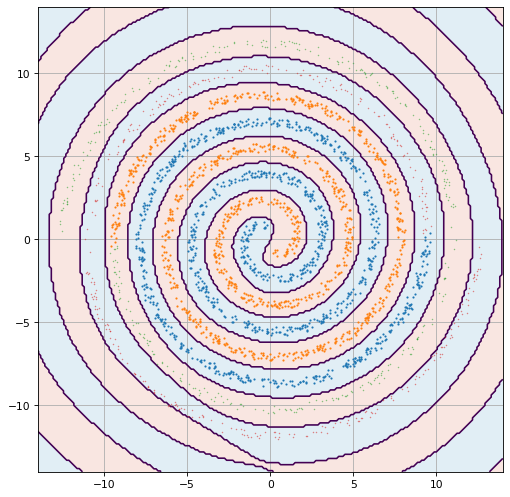

In [3]:
SPIRAL_LR = 0.001
SPIRAL_EPOCHS = 110
from matrix_exponentials import Pade3Expm
res = spiral_run('m_layer', Pade3Expm(6))

In [4]:
expm_time, expm_calls = res[-2], res[-1]
print('ms per expm call', np.sum(expm_time)/np.sum(expm_calls)*1000)
print('expm calls per epoch', np.mean(expm_calls))

ms per expm call 1.1665959378172788
expm calls per epoch 125.0


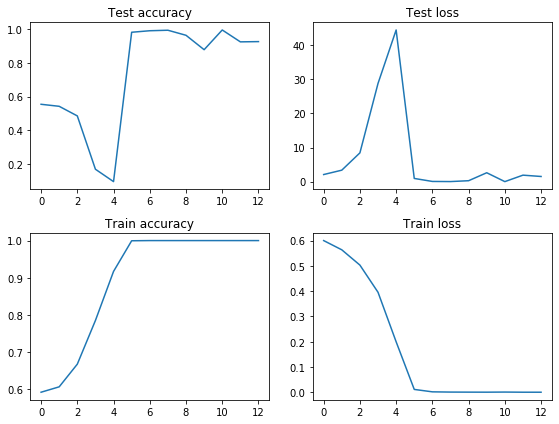

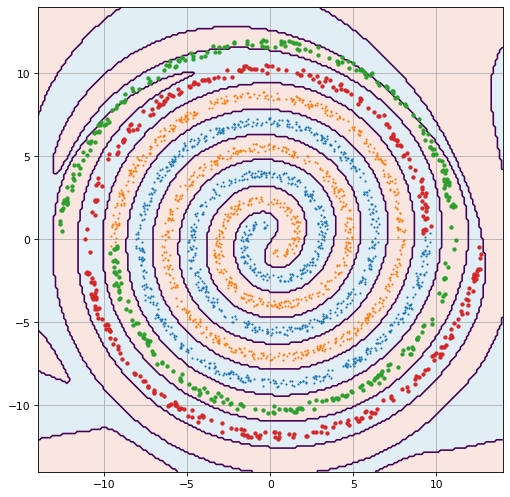

In [7]:
SPIRAL_LR = 0.001
SPIRAL_EPOCHS = 130
from matrix_exponentials import OptimizedTaylor
res = spiral_run('m_layer', OptimizedTaylor(6))

In [8]:
expm_time, expm_calls = res[-2], res[-1]
print('ms per expm call', np.sum(expm_time)/np.sum(expm_calls)*1000)
print('expm calls per epoch', np.mean(expm_calls))

ms per expm call 1.4683155955072869
expm calls per epoch 125.0


### DNN and MLayerNetwork comparison
Here we comapre DNN and MLayerNetwork on the spiral task

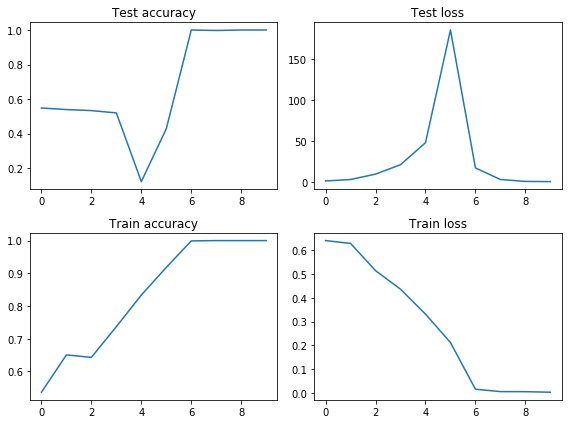

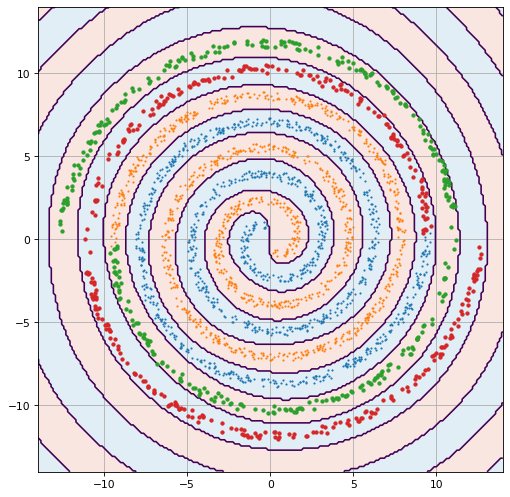

In [3]:
SPIRAL_LR = 0.001
SPIRAL_EPOCHS = 100
from matrix_exponentials import SecondGreatLimitExpm
res = spiral_run('m_layer', SecondGreatLimitExpm(6))

In [4]:
pytorch_total_params = sum(p.numel() for p in res[0].parameters())
print('Total number of parameters in MLayer model:', pytorch_total_params)

Total number of parameters in MLayer model: 1231


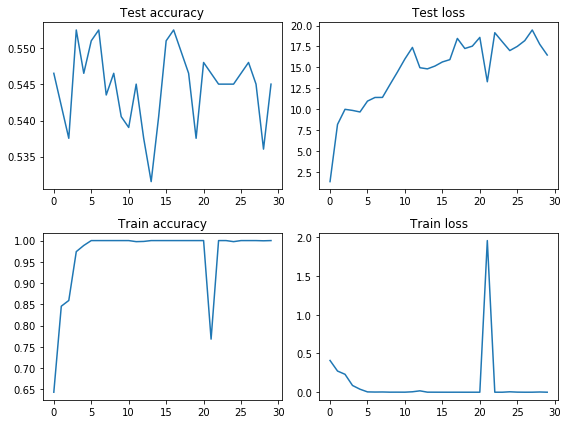

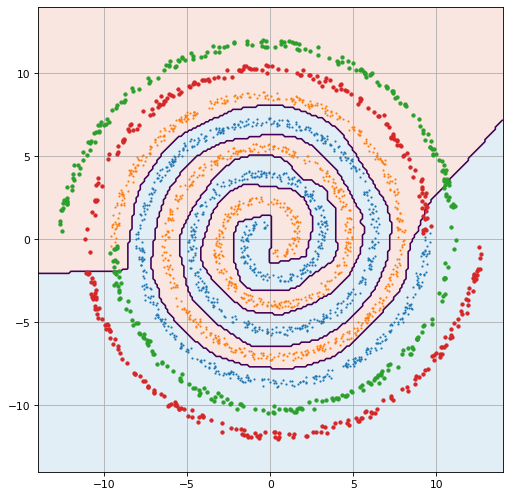

In [5]:
SPIRAL_LR = 0.01
SPIRAL_EPOCHS = 300
SPIRAL_LAYER_SIZE = 64
res = spiral_run('dnn', None)

In [19]:
pytorch_total_params = sum(p.numel() for p in res[0].parameters())
print('Total number of parameters in MLayer model:', pytorch_total_params)

Total number of parameters in MLayer model: 4417
